In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Scrap More Data

In [ ]:
BASE_JSON_DIR = '/content/drive/MyDrive/Casptone/response_jsons'
BASE_DIR = '/content/drive/MyDrive/Casptone/genre_images'

In [ ]:
def API_request(keyword, num_pages, increment=0):
    all_results = []
    for page in range(increment+1, increment+ num_pages + 1):
        link = f"https://unsplash.com/napi/search/photos?page={page}&per_page=30&query={keyword}"
        resp = httpx.get(link)
        if resp.status_code == 200:
            page_results = resp.json().get('results', [])
            all_results.extend(page_results)
        else:
            print(f"Error fetching page {page}: Status code {resp.status_code}")
            break  # Exit the loop if there's an error
    return all_results

In [ ]:
import os
import json
from PIL import Image
import httpx

def load_json_files(keyword, num_pages, increment=0):
    all_results = []
    for page in range(increment+1, increment+ num_pages + 1):
        file_path = f"{BASE_JSON_DIR}/{keyword}_{page}.json"  # Adjust the path if necessary
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                page_results = data.get('results', [])
                all_results.extend(page_results)
        except FileNotFoundError:
            print(f"File {file_path} not found.")
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {file_path}: {e}")
    return all_results

def extract_raw_urls(response_json, skip_premium=True):
    urls = []
    for image_data in response_json:
        if skip_premium and image_data.get('premium', False):
            continue
        raw_url = image_data['urls']['raw']
        trimmed_url = raw_url.split('?')[0]
        urls.append((image_data['id'], trimmed_url))
    return urls

def resize_image(image_path, max_size=(500, 500)):
    try:
        with Image.open(image_path) as img:
            img.thumbnail(max_size, Image.Resampling.LANCZOS)  # Resize while maintaining aspect ratio
            img.save(image_path, format="JPEG")  # Overwrite with the resized image
    except Exception as e:
        print(f"Error resizing image {image_path}: {e}")

def download_images(keyword, urls):
    directory = f"{BASE_DIR}/{keyword}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    print(f"Starting download of {len(urls)} images for {keyword}...")
    for idx, (image_id, url) in enumerate(urls, start=1):
        try:
            image_response = httpx.get(url, timeout=10)  # Set a timeout of 10 seconds
            if image_response.status_code == 200:
                image_path = os.path.join(directory, f"{image_id}.jpg")
                with open(image_path, 'wb') as image_file:
                    image_file.write(image_response.content)
                resize_image(image_path)  # Resize after download
                print(f"{idx}. Downloaded and resized {image_id} to {image_path}")
            else:
                print(f"{idx}. Failed to download image {image_id}: HTTP {image_response.status_code}")
        except (httpx.RequestError, httpx.TimeoutException) as e:
            print(f"{idx}. Error downloading image {image_id}: {e}")
        except Exception as e:
            print(f"{idx}. Unexpected error for image {image_id}: {e}")



In [ ]:
keyword = "historic%20building"
genre = "historical"

In [ ]:
num_pages = 10  # Number of JSON files you have
all_results = API_request(keyword, num_pages, 10)
if all_results:  # Ensure we have results
    urls = extract_raw_urls(all_results)  # Extract URLs, skipping premium images
    if urls:
        print(f"Total images to be downloaded (excluding premium ones): {len(urls)}")
        download_images(genre, urls)
    else:
        print("No non-premium images found for download.")
else:
    print("No results found in the JSON files.")

Total images to be downloaded (excluding premium ones): 275
Starting download of 275 images for historical...
1. Downloaded and resized k8uW_jDFFKw to /content/drive/MyDrive/Casptone/genre_images/historical/k8uW_jDFFKw.jpg
2. Downloaded and resized fuLMdB02uG0 to /content/drive/MyDrive/Casptone/genre_images/historical/fuLMdB02uG0.jpg
3. Downloaded and resized 2LcqsDVFW6A to /content/drive/MyDrive/Casptone/genre_images/historical/2LcqsDVFW6A.jpg
4. Downloaded and resized zWs6IAm7hSo to /content/drive/MyDrive/Casptone/genre_images/historical/zWs6IAm7hSo.jpg
5. Downloaded and resized ULMZdYgzOPo to /content/drive/MyDrive/Casptone/genre_images/historical/ULMZdYgzOPo.jpg
6. Downloaded and resized 9BI4vsfyNt0 to /content/drive/MyDrive/Casptone/genre_images/historical/9BI4vsfyNt0.jpg
7. Downloaded and resized Z95Lecw9roc to /content/drive/MyDrive/Casptone/genre_images/historical/Z95Lecw9roc.jpg
8. Downloaded and resized cjZAdZUHtxY to /content/drive/MyDrive/Casptone/genre_images/historical/cj

KeyboardInterrupt: 

In [ ]:
def count_files_in_directory(directory):
    try:
        # List all items in the directory
        items = os.listdir(directory)
        # Filter only files (not directories)
        file_count = sum(1 for item in items if os.path.isfile(os.path.join(directory, item)))
        return file_count
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
        return 0
count_files_in_directory(f'{BASE_DIR}/{genre}')

399

## Load Dataset

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Casptone/genre_images'

In [ ]:
import os
os.listdir(BASE_DIR)

['museum',
 'park',
 'monument',
 'urban',
 'wildlife',
 'natural_landmark',
 'scenic',
 'historical',
 'religious_site',
 'beach',
 'adventure',
 'art']

In [ ]:
from PIL import Image
import os

# Path to your dataset
# Threshold for the maximum number of pixels (width * height)
max_image_size = 178956970

def check_and_resize_images(directory, max_size, target_size=(300, 300)):
    """
    Traverse the directory, check image size, and resize if necessary.
    """
    for genre_folder in os.listdir(directory):
        genre_path = os.path.join(directory, genre_folder)
        if os.path.isdir(genre_path):  # Ensure it's a folder
            print(f"Processing genre: {genre_folder}")
            for file_name in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file_name)
                if file_name.lower().endswith(('jpg', 'jpeg', 'png')):  # Check for image extensions
                    try:
                        with Image.open(file_path) as img:
                            width, height = img.size
                            size = width * height
                            if size > max_size:
                                print(f"Image {file_name} in {genre_folder} is too large: {size} pixels.")
                                # Resize the image to the target size
                                img = img.resize(target_size)
                                img.save(file_path)
                                print(f"Resized {file_name} to {target_size}.")
                    except Exception as e:
                        print(f"Error processing {file_name}: {e}")

# Run the function
check_and_resize_images(BASE_DIR, max_image_size)

Processing genre: museum
Processing genre: park
Processing genre: monument
Processing genre: urban
Processing genre: wildlife
Processing genre: natural_landmark
Processing genre: scenic
Processing genre: historical
Processing genre: religious_site
Processing genre: beach
Processing genre: adventure
Processing genre: art


In [ ]:
image_size = (150, 150)
batch_size = 32  # Batch size

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.2,          # Randomly zoom into images
    # horizontal_flip=True,    # Randomly flip images horizontally
    # fill_mode='nearest',
    validation_split=0.2,

)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Same validation split
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # For multi-class classification
    subset='training'
)

# Flow from directory for validation data (no augmentation)
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # For multi-class classification
    subset='validation'
)

Found 3916 images belonging to 12 classes.
Found 971 images belonging to 12 classes.


# Without Transfer Learning

## Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',
                          # kernel_regularizer=l2(0.01)
    ),
    tf.keras.layers.Dropout(0.5),  # Dropout remains to prevent overfitting

    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Number of genres
])

In [ ]:
model.compile(
    # optimizer=Adam(learning_rate=0.0005),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       9,470,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,566,540 (36.49 MB)

 Trainable params: 9,566,540 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print(f"Training on {device_name}")

Training on /device:GPU:0


In [ ]:
history = model.fit(
    train_generator,
    epochs=25,  # You can adjust the number of epochs
    validation_data=validation_generator,
)

Epoch 1/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - accuracy: 0.0938 - loss: 2.5728 - val_accuracy: 0.2482 - val_loss: 2.2363
Epoch 2/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - accuracy: 0.2342 - loss: 2.2614 - val_accuracy: 0.2945 - val_loss: 2.0789
Epoch 3/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.2752 - loss: 2.1206 - val_accuracy: 0.3306 - val_loss: 1.9693
Epoch 4/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.3382 - loss: 1.9602 - val_accuracy: 0.3811 - val_loss: 1.8658
Epoch 5/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.3980 - loss: 1.7795 - val_accuracy: 0.3522 - val_loss: 1.9144
Epoch 6/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.4952 - loss: 1.5101 - val_accuracy: 0.3666 - val_loss: 1.9195
Epoch 7/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.5852 - loss: 1.2565 - val_accuracy: 0.3512 - val_loss: 2.0355
Epoch 8/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.6846 - loss: 0

In [ ]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



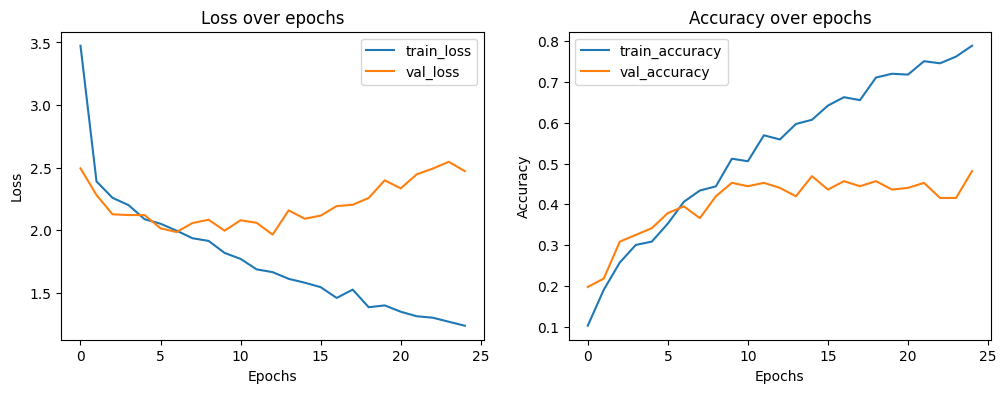

In [ ]:
plot_metrics(history)

## Evaluation

In [ ]:
def preprocess_and_predict(image_path, model, target_size=image_size, top_n=3):
    """
    Preprocess the input image and make a prediction with the model, returning the top_n most probable genres
    along with their softmax probabilities.

    Args:
    - image_path (str): Path to the image file to be tested.
    - model (tf.keras.Model): The trained model for prediction.
    - target_size (tuple): The target size for the image resizing (default is (224, 224)).
    - top_n (int): The number of top predictions to return (default is 3).

    Returns:
    - top_classes (list of tuples): List of top_n predicted class labels and their probabilities.
    """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image (same as during training)

    # Make prediction
    predictions = model.predict(img_array)

    # Sort predictions and get the indices of the top_n most probable classes
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Prepare the list of top classes and their softmax probabilities
    top_classes = [(class_labels[i], predictions[0][i]) for i in top_n_indices]

    # Display the image with the top predicted classes
    plt.imshow(img)
    plt.title(f'Top {top_n} Predicted Genres')
    plt.axis('off')
    plt.show()

    # Return the top_n predicted classes and their softmax probabilities
    return top_classes, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


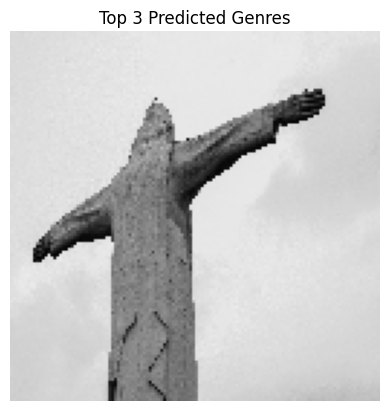

Genre: monument, Probability: 0.7054614424705505
Genre: natural_landmark, Probability: 0.1289166510105133
Genre: beach, Probability: 0.08999621868133545


In [ ]:
# Example usage:
image_path = 'statue.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


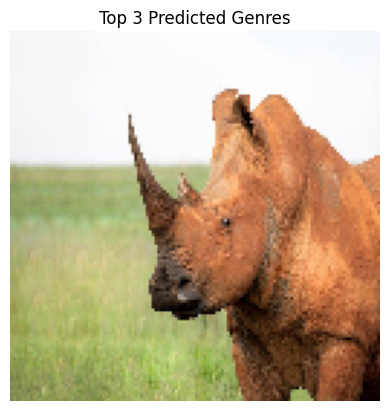

Genre: adventure, Probability: 0.7898690700531006
Genre: wildlife, Probability: 0.06438987702131271
Genre: beach, Probability: 0.058214135468006134


In [ ]:
# Example usage:
image_path = 'badak.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


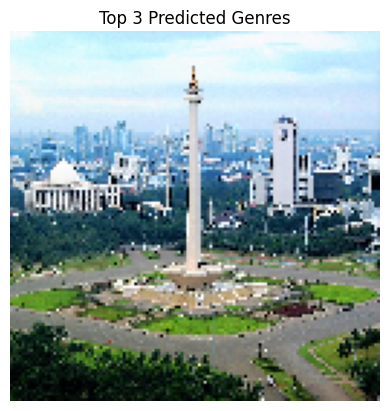

Genre: historical, Probability: 0.5567615628242493
Genre: natural_landmark, Probability: 0.3134249746799469
Genre: park, Probability: 0.04610709473490715


In [ ]:
# Example usage:
image_path = 'monas.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


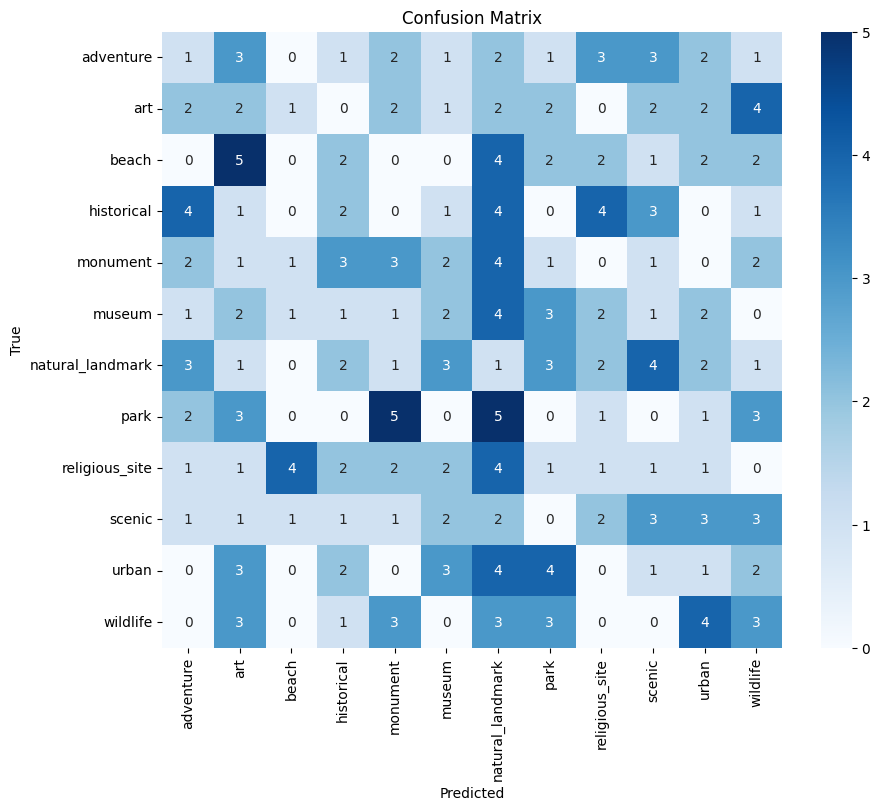

In [ ]:
# Step 1: Make predictions on the validation set
validation_predictions = model.predict(validation_generator, verbose=1)

# Convert predictions to class labels (argmax)
predicted_classes = np.argmax(validation_predictions, axis=1)

# Step 2: Get the true labels (ground truth)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Save Model

In [ ]:
model.save('image_genre_classifier.h5')

# Transfer Learning ResNet

## Model

In [ ]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze the base model (so its weights won't be updated during training)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,  # ResNet50 as the base model

    # Global average pooling to reduce the dimensionality of the feature maps
    tf.keras.layers.GlobalAveragePooling2D(),

    # # Add a dense layer for the classification task
    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),

    # # Dropout layer to prevent overfitting
    # tf.keras.layers.Dropout(0.5),

    # Final classification layer with the number of output classes (genres)
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
model.compile(
    # optimizer=Adam(learning_rate=0.0005),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 12)                  │          24,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train Model

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print(f"Training on {device_name}")

Training on /device:GPU:0


In [ ]:
history = model.fit(
    train_generator,
    epochs=25,  # You can adjust the number of epochs
    validation_data=validation_generator,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - accuracy: 0.0996 - loss: 2.6411 - val_accuracy: 0.0823 - val_loss: 2.5279
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.1140 - loss: 2.5093 - val_accuracy: 0.1687 - val_loss: 2.4482
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.1607 - loss: 2.4125 - val_accuracy: 0.1276 - val_loss: 2.4184
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.1555 - loss: 2.3612 - val_accuracy: 0.1728 - val_loss: 2.3390
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.1900 - loss: 2.3554 - val_accuracy: 0.1111 - val_loss: 2.3684
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.1925 - loss: 2.3095 - val_accuracy: 0.2099 - val_loss: 2.3017
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.2197 - loss: 2.2642 - val_accuracy: 0.1934 - val_loss: 2.2992
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.2223 - loss: 2.2494 - val_accu

In [ ]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



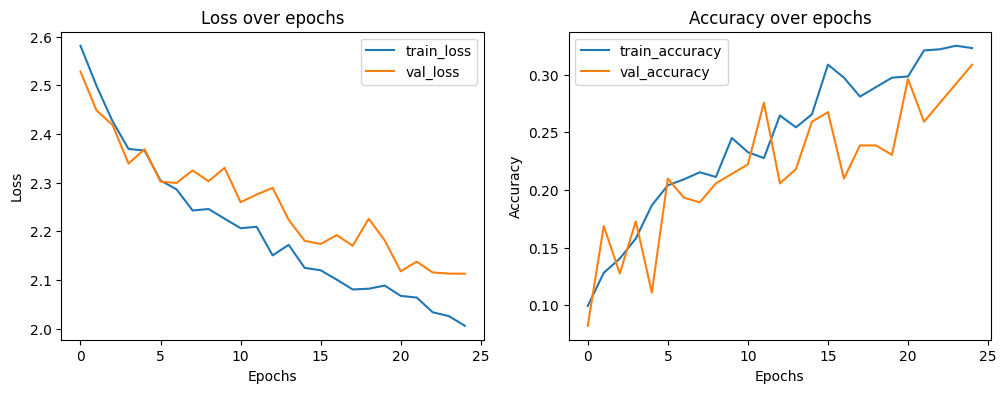

In [ ]:
plot_metrics(history)

## Evaluation

In [ ]:
def preprocess_and_predict(image_path, model, target_size=(300, 300), top_n=3):
    """
    Preprocess the input image and make a prediction with the model, returning the top_n most probable genres
    along with their softmax probabilities.

    Args:
    - image_path (str): Path to the image file to be tested.
    - model (tf.keras.Model): The trained model for prediction.
    - target_size (tuple): The target size for the image resizing (default is (224, 224)).
    - top_n (int): The number of top predictions to return (default is 3).

    Returns:
    - top_classes (list of tuples): List of top_n predicted class labels and their probabilities.
    """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image (same as during training)

    # Make prediction
    predictions = model.predict(img_array)

    # Sort predictions and get the indices of the top_n most probable classes
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Prepare the list of top classes and their softmax probabilities
    top_classes = [(class_labels[i], predictions[0][i]) for i in top_n_indices]

    # Display the image with the top predicted classes
    plt.imshow(img)
    plt.title(f'Top {top_n} Predicted Genres')
    plt.axis('off')
    plt.show()

    # Return the top_n predicted classes and their softmax probabilities
    return top_classes, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


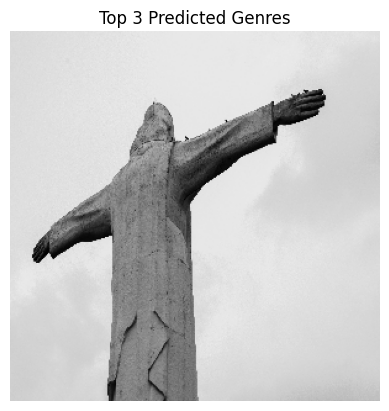

Genre: adventure, Probability: 0.19398443400859833
Genre: wildlife, Probability: 0.14755187928676605
Genre: natural_landmark, Probability: 0.1471618264913559


In [ ]:
# Example usage:
image_path = 'statue.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step


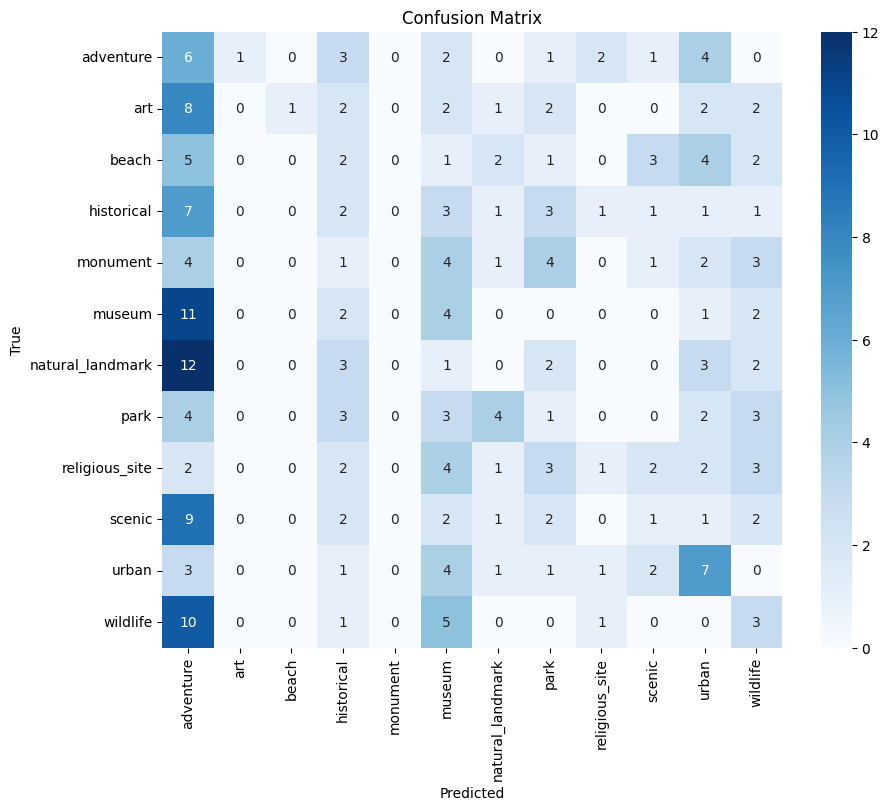

In [ ]:
# Step 1: Make predictions on the validation set
validation_predictions = model.predict(validation_generator, verbose=1)

# Convert predictions to class labels (argmax)
predicted_classes = np.argmax(validation_predictions, axis=1)

# Step 2: Get the true labels (ground truth)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Save Model

In [ ]:
# model.save('image_genre_classifier.h5')

# Transfer Learning MobileNet

## Model

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,

    validation_split=0.2,

)

In [ ]:
train_generator = mobilenet_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'

)

validation_generator = mobilenet_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'

)

Found 975 images belonging to 12 classes.
Found 243 images belonging to 12 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so its weights won't be updated during training)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,  # MobileNet as the base model

    # Global average pooling to reduce the dimensionality of the feature maps
    tf.keras.layers.GlobalAveragePooling2D(),

    # # Add a dense layer for the classification task
    tf.keras.layers.Dense(256, activation='relu'),

    # # Dropout layer to prevent overfitting
    # tf.keras.layers.Dropout(0.5),

    # Final classification layer with the number of output classes (genres)
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
model.compile(
    # optimizer=Adam(learning_rate=0.0005),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train Model

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print(f"Training on {device_name}")

Training on /device:GPU:0


In [ ]:
history = model.fit(
    train_generator,
    epochs=25,  # You can adjust the number of epochs
    validation_data=validation_generator,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.0890 - loss: 2.8563 - val_accuracy: 0.0823 - val_loss: 2.5216
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.0919 - loss: 2.5165 - val_accuracy: 0.1111 - val_loss: 2.4799
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1124 - loss: 2.4478 - val_accuracy: 0.1235 - val_loss: 2.4530
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.1288 - loss: 2.4301 - val_accuracy: 0.1440 - val_loss: 2.4138
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.1398 - loss: 2.4058 - val_accuracy: 0.1440 - val_loss: 2.3956
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.1421 - loss: 2.3638 - val_accuracy: 0.1358 - val_loss: 2.3930
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.1655 - loss: 2.3392 - val_accuracy: 0.1646 - val_loss: 2.3933
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.1701 - loss: 2.3375 - val_accuracy

In [ ]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



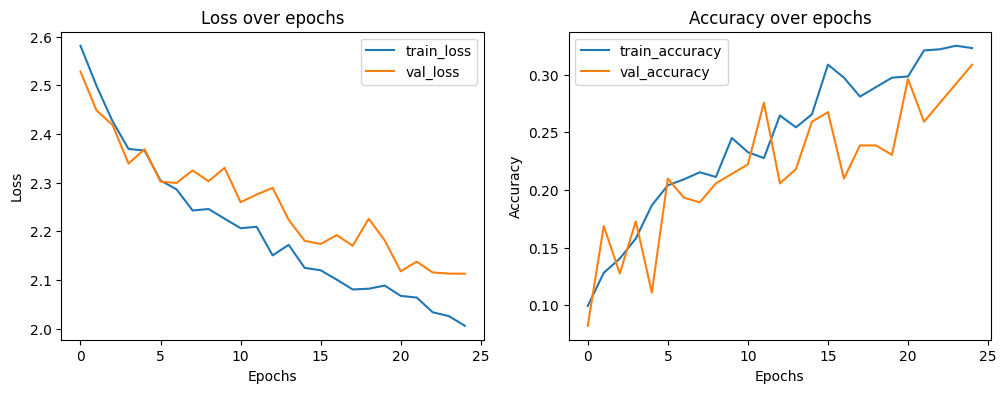

In [ ]:
plot_metrics(history)

## Evaluation

In [ ]:
def preprocess_and_predict(image_path, model, target_size=(300, 300), top_n=3):
    """
    Preprocess the input image and make a prediction with the model, returning the top_n most probable genres
    along with their softmax probabilities.

    Args:
    - image_path (str): Path to the image file to be tested.
    - model (tf.keras.Model): The trained model for prediction.
    - target_size (tuple): The target size for the image resizing (default is (224, 224)).
    - top_n (int): The number of top predictions to return (default is 3).

    Returns:
    - top_classes (list of tuples): List of top_n predicted class labels and their probabilities.
    """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image (same as during training)

    # Make prediction
    predictions = model.predict(img_array)

    # Sort predictions and get the indices of the top_n most probable classes
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Prepare the list of top classes and their softmax probabilities
    top_classes = [(class_labels[i], predictions[0][i]) for i in top_n_indices]

    # Display the image with the top predicted classes
    plt.imshow(img)
    plt.title(f'Top {top_n} Predicted Genres')
    plt.axis('off')
    plt.show()

    # Return the top_n predicted classes and their softmax probabilities
    return top_classes, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


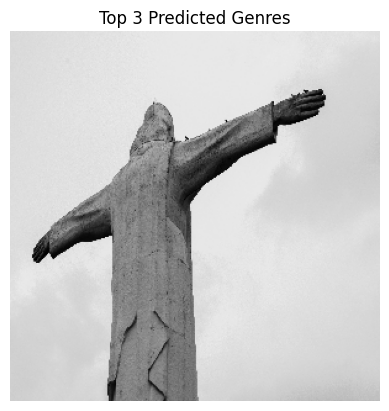

Genre: adventure, Probability: 0.19398443400859833
Genre: wildlife, Probability: 0.14755187928676605
Genre: natural_landmark, Probability: 0.1471618264913559


In [ ]:
# Example usage:
image_path = 'statue.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step


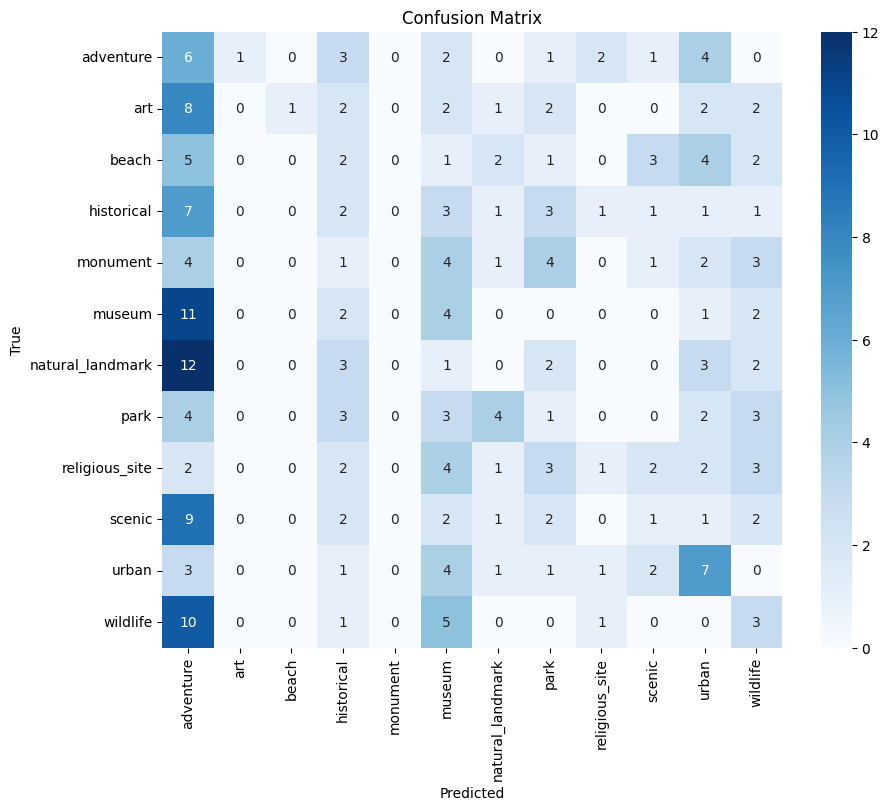

In [ ]:
# Step 1: Make predictions on the validation set
validation_predictions = model.predict(validation_generator, verbose=1)

# Convert predictions to class labels (argmax)
predicted_classes = np.argmax(validation_predictions, axis=1)

# Step 2: Get the true labels (ground truth)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Save Model

In [ ]:
# model.save('image_genre_classifier.h5')